Task

Subtask A: Conspiratorial Content Classification: A system must recognize if a telegram
post is conspiratorial or not.

A sentence is Conspiratorial if either  
(i) expresses the belief that major events(e.g., covid) are manipulation created by powerful people to protect their interests  
 or  
(ii) an interpretation of events meant to contribute to strengthening the underlying narrative of the conspiracy theory.

A sentence is Not Conspiratorial if it does not diffuse any kind of beliefs linked to the conspiracy theory.

Definizione della teoria del complotto

Una teoria del complotto o della cospirazione (talvolta nella forma aggettivale: teoria complottista o cospirativa) è una teoria o spiegazione di un evento o una situazione, spesso alimentata da motivazioni politiche, che ne attribuisce cause e responsabilità a una cospirazione ordita da gruppi elitari e potenti (spesso detti «poteri forti»), nonostante le altre spiegazioni già fornite siano più plausibili e affidabili. Il termine ha una connotazione negativa, poiché implica che il credere a tali teorie sia una pratica basata sul mero pregiudizio e su prove insufficienti. Una «teoria del complotto» non è la stessa cosa di una cospirazione; perché si riferisce a una cospirazione ipotizzata con caratteristiche specifiche, come un'opposizione al consenso tradizionale (talvolta detto «mainstream») tra quelle persone, come scienziati o storici, che sono qualificate per valutarne l'accuratezza.

Le teorie del complotto sono restie alle critiche e al principio di falsificabilità; al contrario trovano forza nella logica circolare: sia le prove che confutano il complotto che l'assenza di prove a favore della sua esistenza sono reinterpretate dai complottisti come indiscutibili dimostrazioni della sua verità, per cui la cospirazione diventa una questione di fede piuttosto che qualcosa che può essere provato o confutato. La ricerca suggerisce che l'ideologia complottista—la fede nelle teorie del complotto—può essere psicologicamente dannosa o patologica e che è correlata a scarso pensiero analitico, basso quoziente d'intelligenza, proiezione psicologica, paranoia e machiavellismo. Gli psicologi attribuiscono il trovare teorie del complotto lì dove non ce ne sono a un fenomeno mentale chiamato «apofenia».

[Fonte](https://it.wikipedia.org/wiki/Teoria_del_complotto)

In [ ]:
%pip install emoji sklearn pandas numpy nltk transformers torch matplotlib seaborn python-dotenv

Documentazioni:  
emoji: https://carpedm20.github.io/emoji/docs/  
Hugchat: https://pypi.org/project/hugchat/


Il dataset presenta una lista di messaggi/post raccolti su vari social, una delle caratteristiche di queste forme di comunicazioni sono le emoticon (o emoji) e la forma del messaggio in se.
Questo significa che un testo che vuole catturare l'attenzione avrà un "titolo" d'impatto e spesso in maiuscolo, in quanto l'attenzione dedicata a questo tipo di contenuti è poca e di carattere transitorio.

Inoltre il dataset presenta una quantità di dati inadatta all'addestramento di un qualsiasi classficatore superabile tramite tecniche di data augmentation, questa caratteristica è intriseca nel problema in quanto i trend [^1] durano molto poco nel tempo e per un sistema di riconoscimento dei contenuti fuorvianti è necessario essere in grado di adattarsi in breve a queste variazioni.

Il dataset ha dimensione eterogenea, il che potrebbe portare a esempi per il transformer dove sono presenti lunghe stringhe di filler.


Di seguito verranno proposte alcune tecniche di preprocessing e di data augmentation


[^1]: Per trend si indica un argomento che cattura l'attenzione del pubblico e che ha orizzonte temporale molto breve, di solito nell'ordine dei giorni.

Possibili tentativi  

Data augmentation
- prendere solo i caratteri ripetuti o parole maiuscole e emoticon dal testo e verificare la label, questo può funzionare in quanto spesso la comunicazione passa per l'impatto della forma  

- utilizzare altri modelli di elaborazione del linguaggio, chiedendo di modificare il testo mantenendone il significato, nascondendone parti o riformulare in modo più o meno aggressivo la frase


Data preprocessing  

- Raccolta di una percentuale della frase per raccogliere il "titolo" 

In [2]:
import numpy
import pandas as pd
from dotenv import load_dotenv
import os
from hugchat import hugchat
from hugchat.login import Login
from tqdm import tqdm
import time
from torch.optim import Adam
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt



C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv('Dataset/subtaskA_train.csv',  header=0, names=['id', 'text', 'label'])
color1 = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
color2 = (0.4, # redness
         0.2, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 


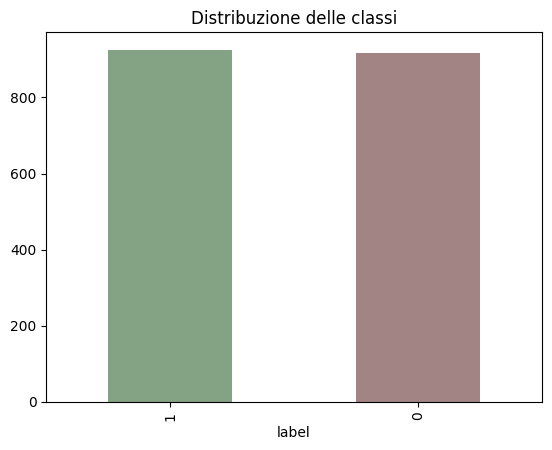

In [15]:
dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()


Per aumentare i dati utilizziamo un chatbot che si interfaccia con [huggingface](https://huggingface.co/chat/) per ottenere l'aumento dei dati, di seguito sono mostrati i prompt provati e quale è stato infine scelto per il compito.

In [4]:
email = os.getenv("EMAIL_HF")
passwd = os.getenv("PASS_HF")
# Log in to huggingface and grant authorization to huggingchat
sign = Login(email, passwd)
cookies = sign.login()

# Save cookies to the local directory
cookie_path_dir = "./cookies_snapshot"
sign.saveCookiesToDir(cookie_path_dir)

chatbot = hugchat.ChatBot(cookies=cookies.get_dict())  

I modelli disponibili sono i seguenti, è possibile cambiare cambiare modello con _chatbot.switch_llm(index)_

In [5]:
models = chatbot.get_available_llm_models()
active_model = chatbot.switch_llm(4)
id = chatbot.new_conversation()
chatbot.change_conversation(id)
print("Modelli disponibili:")
for m in range(len(models)):
    print(models[m])



Modelli disponibili:
meta-llama/Llama-2-70b-chat-hf
codellama/CodeLlama-34b-Instruct-hf
tiiuae/falcon-180B-chat
mistralai/Mistral-7B-Instruct-v0.1
openchat/openchat_3.5


Prompt testati:

1 - "Sei un sistema per fare data augmentation per un task NLP che deve classificare se un testo è  cospirazionista o no, ti verrà fornita una coppia di valori testo-label e dovrai generare nuove righe di dati. I dati generati avranno lo stesso significato di quelli inviati ma con parole diverse. Genererai 4 righe per ogni input di cui: una con lo stesso significato e tono, una riassunta, una con lo stesso significato ed un tono più aggressivo ed  una con lo stesso significato ed un tono più amichevole. I dati forniti sono nella forma text, label,  la label è un valore booleano che indica se il testo è cospirazionista o meno. La label deve essere coerente con il contenuto del testo generato. La lingua del risultato deve essere italiano"

Estrazione del testo: 
'''
import re
def estrai_testo_label(testo):
    
    testo_pattern = r'Testo: "(.*?)"'  
    label_pattern = r'Label: (\d)'  
    riepilogo_pattern = r'Riepilogo: "(.*?)"'  
    riassunto_pattern = r'Riassunto: "(.*?)"'  
    testi = re.findall(testo_pattern, testo)  
    labels = re.findall(label_pattern, testo)  
    riepilogo = re.findall(riepilogo_pattern, testo)  
    riassunto = re.findall(riassunto_pattern, testo)  
    if len(riepilogo) == 0:  
        testi.insert(1, riassunto[0])  
    else:  
        testi.insert(1, riepilogo[0])  
 
    testi_no_contorno = []  
    labels_no_contorno = []  
    
    for i in range(len(testi)):  
        a = testi[i].split(':')  
        b = labels[i].split(':')  
        testi_no_contorno.append(a)  
        labels_no_contorno.append(b)  
    
    return testi_no_contorno, labels_no_contorno  
'''

2 - '
    Input:  
    "Testo originale: {dataset.loc[i,['text']].to_string()}"  

    Output desiderato:  
 
    "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato."  
    "Fornisci un riassunto del testo originale."  
    "Sostituisci alcune parole chiave nel testo originale."  
    "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato ed in lingua italiana."  
    "Trasforma il testo originale in una domanda diretta."  
    
    Tutti gli output devono essere in italiano  
    '
Estrazione del testo:  
'''  
def get_text_clean(text):  
    true_list = [2,4,6,8,10]  
    text = text.split("\n")   
    text_array = [line for line in text if line.strip() != ""]  
    text_array = [i for i in text_array if text_array.index(i) in true_list]  
    return text_array  
'''


Il secondo prompt si è dimostrato più consistente e preciso nelle risposte, per cui viene utilizzato per aumentare il dataset

In [6]:
##Dataset di prova per testare il funzionamento dell'augmenter
df_test = dataset[:5].copy()
df_test['text'] = df_test['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
df_test.head()


,id,text,label
0,0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,1,"21/08/21]( [PRE-PRINT] 📄__ ""Shedding of Infectious SARS-CoV-2 Despite Vaccination"" 🇮🇹 ""Diffusione del SARS-CoV-2 nonostante la vaccinazione""__ 📊 ""La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"" ⚠️ ""[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."" ⚠️ ""[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l'infezione**."" 📚 **",1
2,2,"PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA' La scorsa settimana Elon Musk ha dichiarato di volere che la ""libertà di parola"" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter così scontrandosi frontalmente, e senza paura, con BlackRock, Vanguard e State Street, cioè i tre fondi di inves che controllano il 95% delle multinazionali tra le prime 500 al Mondo. I DEM americani hanno risposto con la grande sorella Hillary e il grande fratello Obama, i quali twittando hanno ordinato di allestire opportuni apparati di censura, una comanda ovviamente presa dai loro camerieri della UE e della ridicola Amministrazione Biden. Si tratta di un disperato tentativo di nascondere le Verità che stanno emergendo sul Covid19 e i vaccini, i supposti morti 'senza correlazione', le elezioni americane e francesi colossalmente truccate, i ladrocini finanziari trilionari con i derivati, i sacrifici umani e soprattutto di bambini e tante altre rivelazioni usando un ""Ministero della Verità"" in perfetto stile Orwell 1984. Questa risposta DEM è assolu incostituzionale e non basta chiamare questi abomini 'Board per la Disinformazione' (in America) o 'Piattaforma per la Disinformazione' (in Unione Europea) per giustificare il tentativo di nascondere la Verità agli occhi della gente, tentando di non sembrare quello che sempre più palesemente si è: Tiranni Globali come quelli descritti in tutta la Letteratura distopica. Ricordo che Twitter aveva censurato la Verità sul laptop di Hunter Biden poco prima delle elezioni del 2020, e se ciò non fosse stato fatto e i media avessero fatto il loro lavoro, tutti sapremmo dei traffici di esseri umani ed energetici all'ombra di BURISMA, la compagnia del gas Ucraino nel cui board sedeva il figlio di Joe Biden dopo il colpo di stato del 2014, per il fine di realizzare in Ucraina quella base della piattaforma del Male oggi usata per alimentare la possibilità di una Terza Guerra Mondiale Nucleare. Le cose stanno precipitando per i DEM con la prospettiva di ricongiungerli ai loro DEMoni ispiratori. In questo senso è al simbolica l'uscita dell'analista politico della CNN David Zurawik di ieri, quando ha detto che è molto pericolosa l'acquisizione di Twitter da parte di Elon Musk, e che l'America deve guardare all'Europa per le risposte. In preda ad un sen di paura e delirio come quello del letterato iconico dei democratici americani, il drogato di adrenocromo Hunter Thompson nel suo famoso romanzo autobiografico ""Paura e Delirio al Las Vegas"", l'opinionista della CNN ha dichiarato: ""Hai bisogno di regolamentazione. Non puoi lasciare che questi ragazzi controllino la narrazione in questo paese o saremo diretti all'inferno. Noi ci siamo. Trump ha aperto le porte dell'inferno e ora ci stanno inseguendo"". Sono d'accordo con David Zurawik ma nel senso che le porte dell'Inferno sono effettivamente spalancate e pronte ad accogliere i meritevoli. Tutti gli esseri umani corrotti dal potere, dalla fama e dal denaro che sono stati strumenti del maligno, avranno il loro posto meritato. Nove, Nove, Nove. P.S. Godetevi il video con la 

In [7]:
def get_prompt_list(dataframe):
    prompt_list = []
    for i in range(len(dataframe)):
        prompt_list.append(f"""
        Input:
        "Testo originale: '''{dataframe.loc[i,['text']].to_string()}'''"

        Output desiderato:

        "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano."
        "Fornisci un riassunto del testo originale in italiano."
        "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano."
        "Sostituisci alcune parole chiave nel testo originale in italiano."
        "Trasforma il testo originale in una domanda diretta in italiano."
        
        Richiesta di risposta (formato predefinito):
        "Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

        [Sinonimi]: [Testo risultante sostituendo le parole chiave con dei sinonimi]
        [Riassunto]: [Riassunto risultante]
        [Tono diverso]: [Testo risultante con tono diverso]
        [Parole chiave sostituite]: [Testo risultante con parole chiave sostituite]
        [Domanda diretta]: [Testo risultante come domanda diretta]"


    """)

    return prompt_list

In [8]:
def get_clean_text(text):
    result = []
    lines = text.split("\n")
    for line in lines:
        if ":" in line:
            start_index = line.index(":") + 1
            result.append(line[start_index:])
    return result

def get_augmented_dataset(array_of_text, original_data, label):
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    df = pd.DataFrame(columns=['text', 'label'])
    augmented_dataset.loc[0]= [original_data, label]
    for i in range(len(array_of_text)):
        df.loc[0]= [array_of_text[i], label]
        augmented_dataset = pd.concat([augmented_dataset,df], ignore_index=True)
    return augmented_dataset


In [9]:
prompt_list = get_prompt_list(df_test)

for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    print(query_result['text'])
    #text_array = get_text_clean(query_result['text'])
    #augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)

_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: Se non avessero esistito soldati, non ci sarebbe stata guerra.
[Riassunto]: Il testo afferma che l'assenza di soldati porterebbe alla mancanza di conflitti.
[Tono diverso]: Eventualmente, se non c'erano soldati, non si potrebbe combattere.
[Parole chiave sostituite]: Nei casi ipotetici, assenti militari, non ci sarebbero stati spargimenti di sangue.
[Domanda diretta]: Ciò è vero? Se non ce ne fosse, non ci sarebbe mai stata guerra?
_getitem_
done
 Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

[Sinonimi]: La dispersione dell'SARS-CoV-2 continua nonostante la vaccinazione; la variante Delta aumenta la carica virale, è altamente transmissibile e presenta mutazioni che consentono una scampatura immunitaria parziale. Le ricerche sulla pandemia suggeriscono che le per

In [72]:
#Da far andare solo una volta per ottenere il dataset aumentato
'''
prompt_list = get_prompt_list(dataset)

augmented_dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    #print(query_result['text'])
    text_array = get_text_clean(query_result['text'])
    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)
augmented_dataset.head()
augmented_dataset = shuffle(augmented_dataset)
augmented_dataset.to_csv('Dataset/augmented_dataset.csv', index=False)
'''

_getitem_
done
_getitem_
done
_getitem_
done
_getitem_
done
_getitem_
done


,text,label
0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,"""Se non ci fossoro combattenti non ci sarebbero conflitti.""",0
2,"""Il testo afferma che l'esistenza di soldati è necessaria per la guerra.""",0
3,"""Se non ci fossoro militi non ci sarebbero battaglie.""",0
4,"""Ah, la pace potrebbe finally arrivare se non ci fossoro quei maledetti soldati!""",0


In [73]:
augmented_dataset = pd.read_csv('Dataset/augmented_dataset.csv',  header=0, names=['text', 'label'])
print(augmented_dataset.head())
augmented_dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()

,text,label
0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,"""Se non ci fossoro combattenti non ci sarebbero conflitti.""",0
2,"""Il testo afferma che l'esistenza di soldati è necessaria per la guerra.""",0
3,"""Se non ci fossoro militi non ci sarebbero battaglie.""",0
4,"""Ah, la pace potrebbe finally arrivare se non ci fossoro quei maledetti soldati!""",0
5,"""Questo è vero: se non ci fossoro soldati non ci sarebbero guerre?""",0
6,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Infectious SARS-CoV-2 Despite Vaccination""\n🇮🇹 ""Diffusione del SARS-CoV-2 nonostante la vaccinazione""__\n\n📊 ""La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta""\n\n⚠️ ""[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**.""\n\n⚠️ ""[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l'infezione**.""\n\n📚 **",1
7,"""La diffusione del SARS-CoV-2 nonostante la vaccinazione è possibile grazie alle mutazioni che conferiscono una fuga immunitaria parziale. Le persone vaccinate possono ancora diffondere la variante Delta del virus.""",1
8,"""Il testo afferma che le persone vaccinate possono diffondere la variante Delta del SARS-CoV-2 nonostante la vaccinazione, poiché il virus presenta mutazioni che lo rendono più contagioso.""",1
9,"""La variante Delta del SARS-CoV-2 può causare elevate cariche virali e è altamente contagiosa, persino per le persone vaccinate. Gli individui infettati dalla variante Delta possono trasmettere l'infezione ai altri.""",1


Definizione del preprocessing

Definizione del data augmentation

Definizione pipeline

In [ ]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "h_dim": 768,
    "patience": 5,
    "min_delta": 0.01,
    "language_model": "meta-llama/Llama-2-70b-chat-hf"
}

In [ ]:
(x_train, x_test, y_train, y_test) = train_test_split(augmented_dataset['text'], augmented_dataset['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split( x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                #sentence_clean = ' '.join([w.lower() for w in sentence])
                #text_clean.append(sentence_clean)
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza
     



Training

Test

Dati dell'addestramento

Altre soluzioni provate, commentate per non farle analizzare in fase di invio